# ------------------
# Metodo di Engelund
# ------------------
#
# Schema per il calcolo della scala di deflusso di sezioni complesse

# =========================
# Import Pacchetti e Moduli
# =========================
import numpy as np # Libreria numerica
from matplotlib import pyplot as plt # Libreria grafica
import os


In [11]:
# ============
# Dati utente
# ============
w_dir = "D:\PhD\hymo_research\Engelund\engelund_gauss"
sezione = "kugart"
file_input = w_dir + "/sezioni_input/" + sezione + ".dat"
file_output = w_dir + "/output/" + sezione + "_out.dat"

In [12]:
# ============
# Dati fiume
# ============
vpoints = 100  # N punti discretizzazione verticale per il calcolo delle Q da inserire nella scala delle portate
g = 9.81  # Accelerazione di gravita'
iF = 0.01  # Pendenza
NG = 4  # Numero di punti di Gauss
tol = 1e-03  # Tolleranza nel calcolo della profondita' critica
MAXITER = 100  # Numero massimo di iterazioni nel calcolo della profondità critica
fs = 10  # Font Size x grafici

In [13]:
# ========
# Funzioni
# ========
def GaussPoints(NG):
    """
    Funzione per il calcolo dei punti e dei pesi di Gauss

    Argomenti
    ---------
    NG: int
       numero di punti di Gauss

    Output
    ------
    p: numpy.ndarray
      array dei punti di Gauss
    w: numpy.ndarray
      array dei pesi
    """
    p, w = None, None
    if NG == 2:
        p = np.array([-1 / np.sqrt(3), +1 / np.sqrt(3)])
        w = np.array([1, 1])
    elif NG == 3:
        p = np.array([-(1 / 5) * np.sqrt(15), 0, (1 / 5) * np.sqrt(15)])
        w = np.array([5 / 9, 8 / 9, 5 / 9])
    elif NG == 4:
        p = np.array(
            [
                +(1 / 35) * np.sqrt(525 - 70 * np.sqrt(30)),
                -(1 / 35) * np.sqrt(525 - 70 * np.sqrt(30)),
                +(1 / 35) * np.sqrt(525 + 70 * np.sqrt(30)),
                -(1 / 35) * np.sqrt(525 + 70 * np.sqrt(30)),
            ]
        )
        w = np.array(
            [
                (1 / 36) * (18 + np.sqrt(30)),
                (1 / 36) * (18 + np.sqrt(30)),
                (1 / 36) * (18 - np.sqrt(30)),
                (1 / 36) * (18 - np.sqrt(30)),
            ]
        )

    return p, w


def MotoUniforme(iF, y, z, ks, Y, NG):
    """
    Calcola i parametri di moto uniforme per assegnato tirante

    Argomenti
    ---------

    iF: float
       pendenza del canale
    y: numpy.ndarray
      coordinate trasversali dei punti della sezione
    z: numpy.ndarray
      coordinate verticali dei punti della sezione
    ks: numpy.ndarray
      coefficienti di scabrezza dei punti della sezione
    Y: float
      profondità alla quale calcolare i parametri di moto uniforme
    NG: int [default=2]
      numero di punti di Gauss

    Output
    ------
    Q: float
      portata alla quale si realizza la profondità Y di moto uniforme
    Omega: float
      area sezione bagnata alla profondita' Y
    b: float
      larghezza superficie libera alla profondita' Y
    alpha: float
      coefficiente di ragguaglio dell'energia alla profondita' Y
    beta: float
      coefficiente di ragguaglio della qdm alla profondita' Y
    """
    # Punti e pesi di Gauss
    xj, wj = GaussPoints(NG)  # Calcola i putni e i pesi di Gauss

    # Dati
    teta_c = 0.03
    delta = 1.65
    ds = 0.005

    # Inizializzo
    Omega = 0  # Area bagnata
    b = 0  # Larghezza superficie libera
    sumQs = 0  # Portata solida
    B = 0
    # I coefficienti di ragguaglio sono relativi a tutta la sezione, si calcolano alla fine.
    num_alpha = 0  # Numeratore di alpha
    num_beta = 0  # Numeratore di beta
    den = 0  # Base del denominatore di alpha e beta
    Yi = Y - (z - z.min())  # Distribuzione trasversale della profondita'
    N = Yi.size  # Numero di punti sulla trasversale

    # N punti trasversali -> N-1 intervalli (trapezi)
    for i in range(N - 1):  # Per ogni trapezio

        #    vertical stripe
        #
        #         dy
        #
        #        o-----o       <- water level
        #        |     |
        #        |     |  YR
        #        |     |
        #        |     o      zR     _ _
        #    YL  |    /       ^       |
        #        |   / dB     |       |
        #        |  /         |       |  dz
        #        | /\\ phi    |       |
        #    zL  o  ------    |       |
        #    ^                |      _|_
        #    |                |
        #    ------------------- z=0

        yL, yR = y[i], y[i + 1]
        zL, zR = z[i], z[i + 1]
        YL, YR = Yi[i], Yi[i + 1]
        dy = yR - yL
        dz = zR - zL
        dB = np.sqrt(dy**2 + dz**2)
        cosphi = dy / dB

        if YL <= 0 and YR <= 0:
            dy, dz = 0, 0
            YL, YR = 0, 0
        elif YL < 0:
            dy = -dy * YR / dz
            dz = YR
            YL = 0
        elif YR < 0:
            dy = dy * YL / dz
            dz = YL
            YR = 0

        # Metodo di Gauss:
        SUM = np.zeros(3)
        ksm = 0
        Ym = 0
        for j in range(NG):

            ksm = (ks[i + 1] - ks[i]) / 2 * xj[j] + (ks[i + 1] + ks[i]) / 2
            Ym = (YR - YL) / 2 * xj[j] + (YR + YL) / 2

            # den
            SUM[0] += wj[j] * ksm * Ym ** (5 / 3)
            # num_alpha
            SUM[1] += wj[j] * ksm**3 * Ym**3
            # num_beta
            SUM[2] += wj[j] * ksm**2 * Ym ** (7 / 3)

        den += dy / 2 * cosphi ** (2 / 3) * SUM[0]
        num_alpha += dy / 2 * cosphi**2 * SUM[1]
        num_beta += dy / 2 * cosphi ** (4 / 3) * SUM[2]

        dOmega = (YR + YL) * dy / 2

        # Calcolo di Omega: superficie della sezione
        Omega += dOmega

        # Calcolo di B: lunghezza del perimetro bagnato

        B += dB

        # Calcolo di b: larghezza della superficie libera
        b += dy

        # Calcolo di b: larghezza della superficie libera
        # Rh=Omega/B

    # Calcolo della portata Q
    Q = np.sqrt(iF) * den

    # Calcolo della capacità di trasporto
    teta1 = (Omega / B) * iF / (delta * ds)
    if teta1 >= teta_c:
        Qs = 8 * (teta1 - teta_c) ** 1.5 * np.sqrt(9.81 * delta * ds**3) * b
    else:
        Qs = 0

    # sumQs += qs
    # Qs = sumQs

    # Condizione per procedere al calcolo anche quando il punto i è sommerso
    # mentre i+1 no.
    if den == 0:
        alpha = None
        beta = None
    else:
        alpha = Omega**2 * num_alpha / den**3
        beta = Omega * num_beta / den**2

    return Q, Omega, b, B, alpha, beta, Qs


def Critica(iF, y, z, ks, Q, NG, MAXITER=100, tol=1e-03):
    """
    Calcolo della profondita' critica ad assegnata portata

    Argomenti
    ---------
    iF: float
       pendenza del canale
    y: numpy.ndarray
      coordinate trasversali dei punti della sezione
    z: numpy.ndarray
      coordinate verticali dei punti della sezione
    ks: numpy.ndarray
      coefficienti di scabrezza dei punti della sezione
    Q: float
      portata
    MAXITER: int [default=100]
      numero massimo di iterazioni per l'algoritmo dicotomico
    tol: float
      tolleranza sull'eccesso di energia per l'algoritmo dicotomico
    NG: int [default=2]
      numero di punti di Gauss nel calcolo dei parametri

    Output
    ------
    Ym: float
       profondita' critica calcolata con il metodo dicotomico
    """
    Ya = 1e-06
    Yb = z.max() - z.min()

    # Calcolo della profondita' critica con il metodo dicotomico
    # La funzione da annullare e' quella per l'eccesso di carico specifico sulla sezione

    if Energia(iF, y, z, ks, Ya, Q, NG) * Energia(iF, y, z, ks, Yb, Q, NG) <= 0:
        for i in range(MAXITER):
            Ym = (Ya + Yb) / 2
            Fa = Energia(iF, y, z, ks, Ya, Q, NG)
            Fb = Energia(iF, y, z, ks, Yb, Q, NG)
            Fm = Energia(iF, y, z, ks, Ym, Q, NG)

            if np.abs(Fm) < tol:
                return Ym
            elif Fa * Fm < 0:
                Yb = Ym
            else:
                Ya = Ym

        print("Maximum number of iteration reached!")
    else:
        print("Solution out of boundaries")

    return None


def Energia(iF, y, z, ks, Y, Q, NG):
    """
    Eccesso di energia rispetto alla critica
    Funzione da annullare per trovare le condizioni critiche
    Argomenti
    ---------
    iF: float
       pendenza del canale
    y: numpy.ndarray
      coordinate trasversali dei punti della sezione
    z: numpy.ndarray
      coordinate verticali dei punti della sezione
    ks: numpy.ndarray
      coefficienti di scabrezza dei punti della sezione
    Y: float
      profondita'
    Q: float
      portata
    NG: int [default=2]
      numero di punti di Gauss nel calcolo dei parametri
    """

    Q_temp, Omega, b, B, alpha, beta, Qs = MotoUniforme(iF, y, z, ks, Y, NG)
    Fr2 = Q**2 / (g * Omega**3 / b)

    return alpha * Fr2 - 1

In [15]:
# =================
# Codice principale
# =================

# Carica File di Input
# --------------------
cs = np.loadtxt(file_input)  # Carica Sezione
y, z, ks = cs[:, 0], cs[:, 1], cs[:, 2]

zmax = 5

# Calcolo della scala di deflusso
# -------------------------------
h = np.linspace(z.min(), zmax, vpoints + 1)[
    1:
]  # Array dei livelli della superficie libera (ma salto il primo: tirante nullo portata nulla)
Y = h - z.min()  # Array dei tiranti

# Inizializzo gli array di output
# -------------------------------
Q = np.zeros(vpoints)  # Portata
Omega = np.zeros(vpoints)  # Area
b = np.zeros(vpoints)  # Larghezza superficie libera
B = np.zeros(vpoints)
alpha = np.zeros(vpoints)  # Coefficiente di ragguaglio dell'energia
beta = np.zeros(vpoints)  # Coefficiente di ragguaglio della qta' di moto
Yc = np.zeros(vpoints)  # Tirante critico
Qs = np.zeros(vpoints)  # Portata solida


# Ciclo sui tiranti
# -----------------
# Per ciascun livello della superficie libera calcolo la portata defluente in condizioni
# di moto uniforme, i coefficienti di ragguaglio e la geometria della sezione bagnata
for n in range(vpoints):

    # Calcola i parametri di moto uniforme assegnato il tirante
    Q[n], Omega[n], b[n], B[n], alpha[n], beta[n], Qs[n] = MotoUniforme(
        iF, y, z, ks, Y[n], NG
    )

    # Calcola il livello critico associato alla portata corrispondente
    # al livello di moto uniform corrente
    Yc[n] = Critica(iF, y, z, ks, Q[n], NG, MAXITER=MAXITER, tol=tol)

    # Calcolo del tirante critico
    Yc_ana = (Q[n] ** 2 / (g * b[n] ** 2)) ** (1 / 3)

#    print("Tirante critico numerico = %f Tirante analitico = %f" % (Yc[n],Yc_ana))

# Print Qs array
# print(*Qs)

# Salva File di Output
# --------------------
out_table = np.array([Y, Q, Yc, b, B, Omega, alpha, beta, Qs]).T
np.savetxt(file_output, out_table)

Solution out of boundaries
Solution out of boundaries
Solution out of boundaries
Solution out of boundaries
Solution out of boundaries
Solution out of boundaries
Solution out of boundaries
Solution out of boundaries
Solution out of boundaries
Solution out of boundaries
Solution out of boundaries
Solution out of boundaries
Solution out of boundaries
Solution out of boundaries
Solution out of boundaries
Solution out of boundaries
Solution out of boundaries
Solution out of boundaries
Solution out of boundaries
Solution out of boundaries
Solution out of boundaries
Solution out of boundaries
Solution out of boundaries
Solution out of boundaries
Solution out of boundaries
Solution out of boundaries
Solution out of boundaries
Solution out of boundaries
Solution out of boundaries
Solution out of boundaries
Solution out of boundaries
Solution out of boundaries
Solution out of boundaries
Solution out of boundaries
Solution out of boundaries
Solution out of boundaries
Solution out of boundaries
S

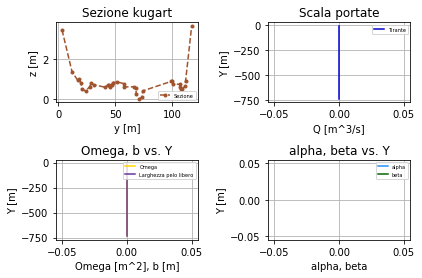

In [16]:
# Crea i grafici
# --------------
fig, ax = plt.subplots(2, 2)

# Sezione y vs. z
ax[0, 0].plot(
    y, z - z.min(), "--.", color="sienna", label="Sezione"
)  # Sezione trasversale
ax[0, 0].set_xlabel("y [m]", fontsize=fs)
ax[0, 0].set_ylabel("z [m]", fontsize=fs)
ax[0, 0].grid()
ax[0, 0].set_title("Sezione " + sezione, fontsize=1.2 * fs)
ax[0, 0].legend(loc="best", fontsize=0.5 * fs)

# Scala di deflusso. Q vs Y, Yc
ax[0, 1].plot(Qs, Y, color="mediumblue", label="Tirante")  # Scala delle portate
# ax[0,1].plot(Q, Y, color='darkred', label = 'Tirante critico') #Scala delle portate-Tirante critico
ax[0, 1].set_xlabel("Q [m^3/s]", fontsize=fs)
ax[0, 1].set_ylabel("Y [m]", fontsize=fs)
ax[0, 1].grid()
ax[0, 1].set_title("Scala portate", fontsize=1.2 * fs)
ax[0, 1].legend(loc="best", fontsize=0.5 * fs)

# Omega, b vs. Y
ax[1, 0].plot(Omega, Y, color="gold", label="Omega")
ax[1, 0].plot(b, Y, color="rebeccapurple", label="Larghezza pelo libero")
ax[1, 0].set_xlabel("Omega [m^2], b [m]", fontsize=fs)
ax[1, 0].set_ylabel("Y [m]", fontsize=fs)
ax[1, 0].grid()
ax[1, 0].set_title("Omega, b vs. Y", fontsize=1.2 * fs)
ax[1, 0].legend(loc="best", fontsize=0.5 * fs)

# alpha, beta vs. Y
ax[1, 1].plot(alpha, Y, color="dodgerblue", label="alpha")
ax[1, 1].plot(beta, Y, color="darkgreen", label="beta")
ax[1, 1].set_xlabel("alpha, beta", fontsize=fs)
ax[1, 1].set_ylabel("Y [m]", fontsize=fs)
ax[1, 1].grid()
ax[1, 1].set_title("alpha, beta vs. Y", fontsize=1.2 * fs)
ax[1, 1].legend(loc="best", fontsize=0.5 * fs)

plt.tight_layout()  # Ottimizza gli spazi
plt.subplots_adjust(top=0.9)
plt.savefig(w_dir + "/plot/plot_" + sezione + ".pdf", dpi=1000)
plt.show()

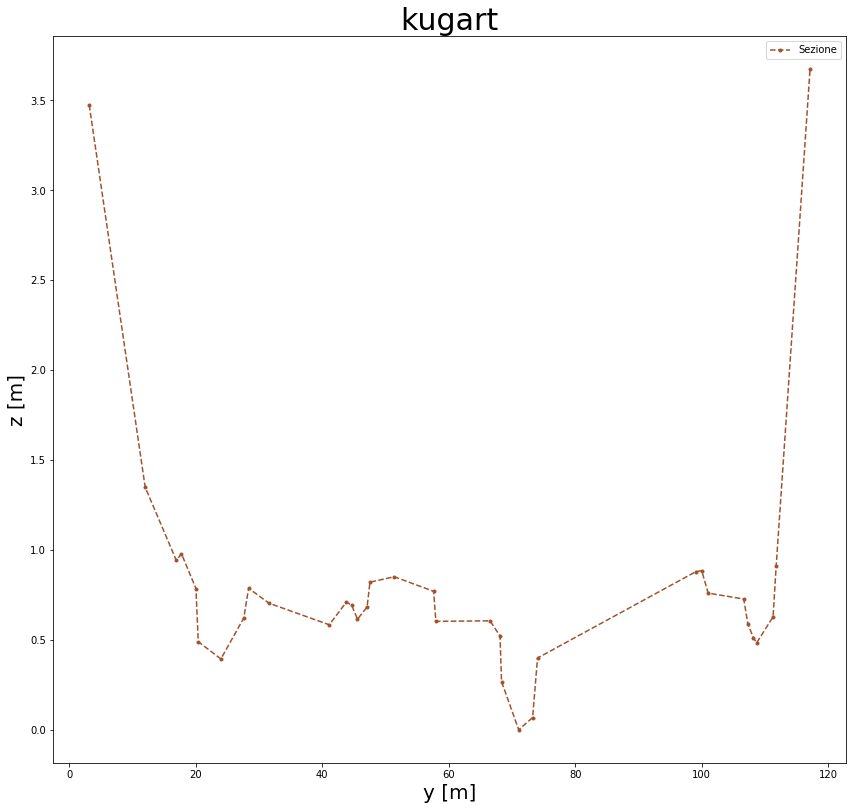

In [7]:
# Plot Sezione
# Scala di deflusso. Q vs Y, Yc
fig, ax = plt.subplots(figsize=(12, 12))
# ax.plot(Q, Y, color='mediumblue', label = 'Tirante') #Scala delle portate

# ax.set_xlim([0, 20])
ax.plot(y, z - z.min(), "--.", color="sienna", label="Sezione")  # Sezione trasversale
ax.set_xlabel("y [m]", fontsize=2 * fs)
ax.set_ylabel("z [m]", fontsize=2 * fs)
ax.grid()
ax.set_title("Sezione " + sezione, fontsize=3 * fs)
ax.legend(loc="best", fontsize=2 * fs)

plt.grid()
ax.set_title(sezione, fontsize=3 * fs)
ax.legend(loc="best", fontsize=fs)
plt.tight_layout()  # Ottimizza gli spazi
plt.subplots_adjust(top=0.9)
plt.savefig(w_dir + "/plot/plot_" + sezione + "2" + ".png", dpi=1000)
plt.show()

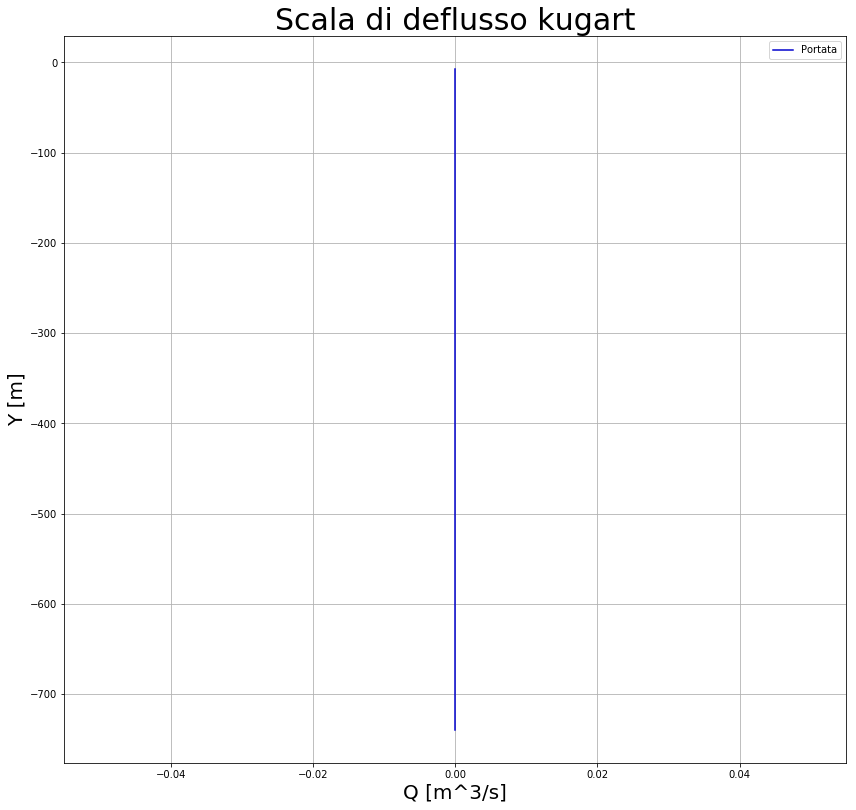

In [8]:
# Plot Qs
# Scala di deflusso. Q vs Y, Yc
fig, ax = plt.subplots(figsize=(12, 12))
ax.plot(Q, Y, color="mediumblue", label="Portata")  # Scala delle portate
# ax.plot(Qs, Y, color='darkred', label = 'Trasporto Solido') #Scala delle portate-Tirante critico
ax.set_xlabel("Q [m^3/s]", fontsize=2 * fs)
ax.set_ylabel("Y [m]", fontsize=2 * fs)
# ax.set_xlim([0, 20])
plt.grid()
ax.set_title("Scala di deflusso " + sezione, fontsize=3 * fs)
ax.legend(loc="best", fontsize=fs)
plt.tight_layout()  # Ottimizza gli spazi
plt.subplots_adjust(top=0.9)
plt.savefig(w_dir + "/plot/plot_" + sezione + "3" + ".png", dpi=1000)
plt.show()

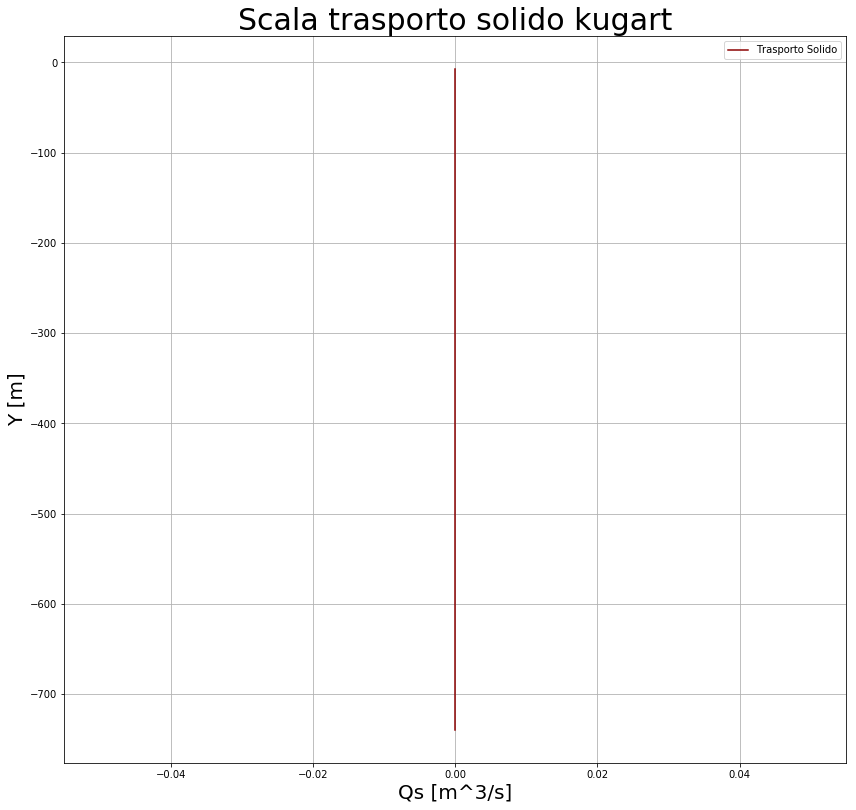

In [9]:
# Plot Qs
# Scala di deflusso. Q vs Y, Yc
fig, ax = plt.subplots(figsize=(12, 12))
# ax.plot(Q, Y, color='mediumblue', label = 'Tirante') #Scala delle portate
ax.plot(
    Qs, Y, color="darkred", label="Trasporto Solido"
)  # Scala delle portate-Tirante critico
ax.set_xlabel("Qs [m^3/s]", fontsize=2 * fs)
ax.set_ylabel("Y [m]", fontsize=2 * fs)
# ax.set_xlim([0, 20])
plt.grid()
ax.set_title("Scala trasporto solido " + sezione, fontsize=3 * fs)
ax.legend(loc="best", fontsize=fs)
plt.tight_layout()  # Ottimizza gli spazi
plt.subplots_adjust(top=0.9)
plt.savefig(w_dir + "/plot/plot_" + sezione + "1" + ".png", dpi=1000)
plt.show()